<a href="https://colab.research.google.com/github/BankNatchapol/Comparison-of-Quantum-Gradient/blob/main/discrete_vs_continuous/analytic_continuous_gradient_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane-sf
!pip install qiskit
!pip install qiskit_optimization

     |████████████████████████████████| 4.9 MB 29.6 MB/s 
     |████████████████████████████████| 881 kB 49.7 MB/s 
     |████████████████████████████████| 8.2 MB 37.2 MB/s 
     |████████████████████████████████| 1.6 MB 45.2 MB/s 
     |████████████████████████████████| 108 kB 55.7 MB/s 
     |████████████████████████████████| 83 kB 2.8 MB/s 
     |████████████████████████████████| 138 kB 74.3 MB/s 
     |████████████████████████████████| 47 kB 6.2 MB/s 
     |████████████████████████████████| 112 kB 72.7 MB/s 
     |████████████████████████████████| 103 kB 54.2 MB/s 
     |████████████████████████████████| 127 kB 79.3 MB/s 
     |████████████████████████████████| 10.9 MB 54.3 MB/s 
     |████████████████████████████████| 87 kB 6.4 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=f3c22dcbe79ec0903dd5eb775a817c85a5b609b8873309e4ab2f8b568ef403f1
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb

In [2]:
import pennylane as qml
from pennylane import numpy as np

from pandas.plotting import table 
import pandas as pd
import time 

import networkx as nx
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objects as go
import plotly.express as px

from docplex.mp.model import Model
from qiskit.opflow import Z, X, Y, I
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications import Maxcut, Clique, Knapsack
from qiskit_optimization.converters import QuadraticProgramToQubo

In [3]:
#@title Auxilary Function
def Had(wires):
  qml.RY(np.pi/2, wires=wires)
  qml.RX(np.pi, wires=wires)


def fully_connected_layer(num_wires):
  if num_wires>1:
    for wire in range(num_wires-1):
      qml.CNOT(wires=[wire, wire+1])
    qml.CNOT(wires=[wire+1, 0])

def fully_connected_layer_cv(num_wires, var):
  if num_wires>1:
    for wire in range(num_wires-1):
      qml.Beamsplitter(var[wire], np.pi/2, wires=[wire, wire+1])
    qml.Beamsplitter(var[-1], np.pi/2, wires=[wire+1, 0])

def str2gate(gate):
  if gate == 'H':
    return Had
  elif gate == 'X':
    return qml.PauliX
  elif gate == 'Y':
    return qml.PauliY
  elif gate == 'Z':
    return qml.PauliZ
  elif gate == 'RX':
    return qml.RX
  elif gate == 'RY':
    return qml.RY
  elif gate == 'RZ':
    return qml.RZ
  else:
    assert 0, "Gate not support."

def controlStr(gate):
  if gate == 'RX':
    return qml.CNOT
  elif gate == 'RY':
    return qml.CY
  elif gate == 'RZ':
    return qml.CZ
  else:
    assert 0, "Gate not support."
    
def hamiltonian_from_qiskit(sum_op):

	'''
	This function takes a qiskit.PauliSumOp as input and
	gives back a Pennylane Hamiltonian as output

	sum_op  = qiskit.PauliSumOp

	'''
	op      = sum_op.primitive.to_list()
	n_terms = len(op)
	coeffs  = []
	paulis  = []

	for i in range(n_terms):
		paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))))
		coeffs.append(op[i][1].real)

	p_op = qml.Hamiltonian(coeffs,paulis)

	return p_op

def hamiltonian_from_qiskit_lcu(sum_op):

  '''
  This function takes a qiskit.PauliSumOp as input and
  gives back a Pennylane Hamiltonian as output

  sum_op  = qiskit.PauliSumOp

  '''
  op      = sum_op.primitive.to_list()
  n_terms = len(op)
  coeffs  = []
  paulis  = []

  for i in range(n_terms):
    if op[i][0]=="I":
      paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))))
    else:
      paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))+"Z"))
    coeffs.append(op[i][1].real)

  p_op = qml.Hamiltonian(coeffs,paulis)

  return p_op

def get_adjacency_matrix(elist):
  adjacency_matrix = np.zeros([num_wires, num_wires])

  for i,j in elist:
    adjacency_matrix[i, j] = 1.0
    adjacency_matrix[j, i] = 1.0

  return adjacency_matrix

def draw_graph(elist, colors):
  G = nx.Graph()
  #G.add_nodes_from(np.arange(0, n, 1))
  # tuple is (i,j,weight) where (i,j) is the edge
  G.add_edges_from(elist)
  pos = nx.spring_layout(G)
  default_axes = plt.axes(frameon=True)
  nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)

def int_to_binary(value, size):
  """Function that converts an integer to a binary string."""

  bi = "{0:b}".format(value)
  if len(bi)<size:
    bi = "0"*(size-len(bi)) + bi
  return bi

# **Gradient methods**

## Continuous-variable

### Parameter shift rule

In [4]:
def parameter_shift_cv_term(qnode, params, i, j, gate):
    s = 0.1
    alpha = np.pi/2
    

    shifted = params.copy()

    if gate == 'R' or gate == 'S2' or gate == 'D2' or gate == 'BS1':
      shifted[i, j] += alpha
      forward = qnode(shifted)  # forward evaluation

      shifted[i, j] -= 2*alpha
      backward = qnode(shifted) # backward evaluation

      return (1/2) * (forward - backward)

    elif gate == 'S1':
      shifted[i, j] += s
      forward = qnode(shifted)  # forward evaluation

      shifted[i, j] -= 2*s
      backward = qnode(shifted) # backward evaluation

      return (1/(2*np.sinh(s))) * (forward - backward)
    
    elif gate == 'D1' or gate == 'QP':
      shifted[i, j] += s
      forward = qnode(shifted)  # forward evaluation

      shifted[i, j] -= 2*s
      backward = qnode(shifted) # backward evaluation

      return (1/(2*s)) * (forward - backward)

def parameter_shift_cv(qnode, params, ansatz_label_cv):

    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gate = ansatz_label_cv[i*len(gradients[0]) + j]
            gradients[i, j] += parameter_shift_cv_term(qnode, params, i, j, gate)

    return gradients

### Finite difference

In [5]:
def finite_cv_term(qnode, params, i, j):
    
    eps = 0.01

    shifted = params.copy()
    
    shifted[i, j] += eps
    forward = qnode(shifted)  # forward evaluation

    shifted[i, j] -= 2*eps
    backward = qnode(shifted) # backward evaluation

    return (1/(2*eps)) * (forward - backward)

def finite_difference_cv(qnode, params):
    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] += finite_cv_term(qnode, params, i, j)

    return gradients

# **Problem Fomulation** 

## Max-Cut

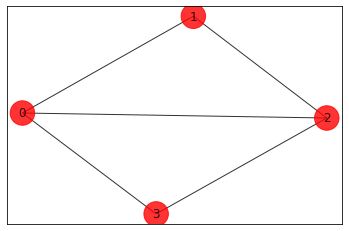

In [6]:
num_wires = 4  # Number of nodes in graph

elist_maxcut = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
colors_maxcut = ["r" for node in range(num_wires)]

draw_graph(elist_maxcut, colors_maxcut)

In [7]:
adjacency_matrix_maxcut = get_adjacency_matrix(elist_maxcut)
max_cut = Maxcut(adjacency_matrix_maxcut)
qp_maxcut = max_cut.to_quadratic_program()
print(qp_maxcut.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 3 x_0 + 2 x_1 + 3 x_2 + 2 x_3 + [ - 4 x_0*x_1 - 4 x_0*x_2 - 4 x_0*x_3
      - 4 x_1*x_2 - 4 x_2*x_3 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



In [8]:
qubitOp_maxcut, offset_maxcut = qp_maxcut.to_ising()
H_maxcut = hamiltonian_from_qiskit(qubitOp_maxcut)
H_maxcut_lcu = hamiltonian_from_qiskit_lcu(qubitOp_maxcut)
print("Offset:", offset_maxcut,"\n")
print("Ising Hamiltonian:\n")

print(H_maxcut)

Offset: -2.5 

Ising Hamiltonian:

  (0.5) [Z2 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z0 Z3]
+ (0.5) [Z0 Z2]
+ (0.5) [Z0 Z1]


## Clique

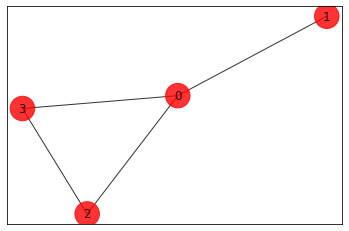

In [9]:
num_wires = 4  # Number of nodes in graph

elist_clique = [(0, 1), (0, 2), (0, 3), (2, 3)]
colors_clique = ["r" for node in range(num_wires)]

draw_graph(elist_clique, colors_clique)

In [10]:
adjacency_matrix_clique = get_adjacency_matrix(elist_clique)
clique = Clique(adjacency_matrix_clique)
qp_clique = clique.to_quadratic_program()
print(qp_clique.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Clique

Maximize
 obj: x_0 + x_1 + x_2 + x_3
Subject To
 c0: x_1 + x_2 <= 1
 c1: x_1 + x_3 <= 1

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



In [11]:
qp2qubo = QuadraticProgramToQubo()
qubo_clique = qp2qubo.convert(qp_clique)

qubitOp_clique, offset_clique = qubo_clique.to_ising()
H_clique = hamiltonian_from_qiskit(qubitOp_clique)
H_clique_lcu = hamiltonian_from_qiskit_lcu(qubitOp_clique)

print("Offset:", offset_clique,"\n")
print("Ising Hamiltonian:\n")

print(H_clique)

Offset: 0.5 

Ising Hamiltonian:

  (-2.0) [Z1]
+ (-0.75) [Z3]
+ (-0.75) [Z2]
+ (0.5) [Z0]
+ (1.25) [Z1 Z3]
+ (1.25) [Z1 Z2]


## Binary Linear Programming

In [12]:
blp = Model("docplex model")
x1 = blp.binary_var("x1")
x2 = blp.binary_var("x2")
x3 = blp.binary_var("x3")
x4 = blp.binary_var("x4")

blp.minimize(195000*x1 + 96000*x2 + 87000*x3 + 120000*x4)
blp.add_constraint(x1  + x3 >= 1)
blp.add_constraint(x2 + x4 >= 1)

# load from a Docplex model
qp_blp = from_docplex_mp(blp)
print(qp_blp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: 195000 x1 + 96000 x2 + 87000 x3 + 120000 x4
Subject To
 c0: x1 + x3 >= 1
 c1: x2 + x4 >= 1

Bounds
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x1 x2 x3 x4
End



In [13]:
qubo_blp = qp2qubo.convert(qp_blp)

qubitOp_blp, offset_blp = qubo_blp.to_ising()
H_blp = hamiltonian_from_qiskit(qubitOp_blp)
H_blp_lcu = hamiltonian_from_qiskit_lcu(qubitOp_blp)

print("Offset:", offset_blp,"\n")
print("Ising Hamiltonian:\n")

print(H_blp)

Offset: 498000.5 

Ising Hamiltonian:

  (27000.25) [Z0]
+ (64500.25) [Z3]
+ (76500.25) [Z1]
+ (81000.25) [Z2]
+ (124500.25) [Z1 Z3]
+ (124500.25) [Z0 Z2]


## Knapsack

In [14]:
weights = [1, 2]
profits = [2, 1]
max_weight = 3
knapsack = Knapsack(profits, weights, max_weight)
qp_ks = knapsack.to_quadratic_program()
print(qp_ks.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Maximize
 obj: 2 x_0 + x_1
Subject To
 c0: x_0 + 2 x_1 <= 3

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1

Binaries
 x_0 x_1
End



In [15]:
qubo_ks = qp2qubo.convert(qp_ks)

qubitOp_ks, offset_ks = qubo_ks.to_ising()
H_ks = hamiltonian_from_qiskit(qubitOp_ks)
H_ks_lcu = hamiltonian_from_qiskit_lcu(qubitOp_ks)

print("Offset:", offset_ks,"\n")
print("Ising Hamiltonian:\n")

print(H_ks)

Offset: 8.5 

Ising Hamiltonian:

  (0.5) [Z1]
+ (1.0) [Z0]
+ (2.0) [Z0 Z2]
+ (4.0) [Z2 Z3]
+ (4.0) [Z1 Z2]
+ (4.0) [Z0 Z3]
+ (4.0) [Z0 Z1]
+ (8.0) [Z1 Z3]


# **Optimization**

## Discrete-variable

In [16]:
# guesting ansatz state

def ansatz_label_cv(num_wires, num_layers):
  label = []
  for l in range(num_layers):
    for wire in range(num_wires):
      label.append("R")
      label.append("D1")
    for wire in range(num_wires):
      label.append("BS1")
  return label

def ansatz_cv(var, num_wires_cv):
    for wire in range(num_wires_cv):
      qml.Rotation(var[0+2*wire], wires=wire)
      qml.Displacement(var[1+2*wire], 0.0, wires=wire)
    fully_connected_layer_cv(num_wires, var[2+2*(num_wires_cv-1):])

In [17]:
def cost_function_cv(var, problem, num_wires, cutoff_dim):
  
  dev = qml.device("strawberryfields.fock", wires=num_wires, cutoff_dim=cutoff_dim)
  @qml.qnode(dev)
  def circuit(var):
    for v in var: 
      ansatz_cv(v, num_wires)
    return [qml.expval(qml.X(i)) for i in range(num_wires)]
  
  answer = circuit(var)
  bi_answer = [a/(cutoff_dim-1) for a in answer]
  return problem.objective.evaluate(bi_answer)

Probability distribution of estimated gate 

In [18]:
# prediction circuit
def prediction_cv(var, num_param_gates, cutoff_dim):
  num_wires = len(var[0])//num_param_gates
  dev = qml.device("strawberryfields.fock", wires=num_wires, cutoff_dim=cutoff_dim)
  @qml.qnode(dev)
  def circuit(var):
    for v in var: 
      ansatz_cv(v, num_wires)
    return [qml.expval(qml.X(i)) for i in range(num_wires)] 
  
  answer = circuit(var)
  bi_answer = [a/(cutoff_dim-1) for a in answer]
  return bi_answer

In [19]:
np.random.seed(2)
num_layers = 2
num_param_gates = 3
cutoff_dim = 5

var_init_maxcut = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))
var_init_clique = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))
var_init_blp = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))
var_init_ks = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

steps = [2, 4, 6, 8, 10]

In [20]:
print("Initial cost: ", -cost_function_cv(var_init_maxcut, qp_maxcut, len(H_maxcut.wires), cutoff_dim))

Initial cost:  0.5241056650101386


In [21]:
print("Prediction: ", prediction_cv(var_init_maxcut, num_param_gates, cutoff_dim))

Prediction:  [tensor(-0.31783798, requires_grad=True), tensor(0.1222664, requires_grad=True), tensor(0.06991624, requires_grad=True), tensor(-0.05206348, requires_grad=True)]


Function for training optimizer

In [22]:
def train(cost_fn, grad_fn, epochs, var_init, lr):
  lost_list = []
  time_list = []

  var = var_init.copy()

  opt = qml.RMSPropOptimizer(lr)

  start = time.time()

  for it in range(epochs):# while True:
      var, _cost = opt.step_and_cost(cost_fn, var, grad_fn=grad_fn) 
      lost_list.append(_cost)

      if it%10==0:
        print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

      end = time.time()
      t = end - start
      time_list.append(t)

  return lost_list, time_list, var

Varaible List

In [23]:
# lost list
cvpsl = []
cvfdl = []

# time list
cvpst = []
cvfdt = []


# lost list change num layer
cvpslc = []
cvfdlc = []

# time list change num layer
cvpstc = []
cvfdtc = []

### Parameter Shift Rule

#### Max-Cut

In [24]:
lr = 0.03
epochs = 101

label = ansatz_label_cv(len(H_maxcut.wires), len(var_init_maxcut))

cost_fn = lambda v: -cost_function_cv(v, qp_maxcut, len(H_maxcut.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: -cost_function_cv(x, qp_maxcut, len(H_maxcut.wires), cutoff_dim), var, label)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)

cvpsl.append(lost_list)
cvpst.append(time_list)

Iter:     0 | Cost: 0.52410566501 
Iter:    10 | Cost: -2.40159649597 
Iter:    20 | Cost: -2.45393151653 
Iter:    30 | Cost: -2.56680260074 
Iter:    40 | Cost: -2.70715022618 
Iter:    50 | Cost: -2.81128418505 
Iter:    60 | Cost: -2.86197685654 
Iter:    70 | Cost: -2.87492866001 
Iter:    80 | Cost: -2.88189850525 
Iter:    90 | Cost: -2.81907735862 
Iter:   100 | Cost: -2.77116033294 


In [25]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))
  label = ansatz_label_cv(len(H_maxcut.wires), len(var_init_maxcutc))
  cost_fn = lambda v: -cost_function_cv(v, qp_maxcut, len(H_maxcut.wires), cutoff_dim)
  grad_fn = lambda var: parameter_shift_cv(lambda x: -cost_function_cv(x, qp_maxcut, len(H_maxcut.wires), cutoff_dim), var, label)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvpslc.append(temp1)
cvpstc.append(temp2)

Iter:     0 | Cost: 2.17379373566 
Iter:    10 | Cost: -2.20232514301 
Iter:     0 | Cost: -1.04051860856 
Iter:    10 | Cost: -2.47917169645 
Iter:     0 | Cost: 0.24289474443 
Iter:    10 | Cost: -2.77269920169 
Iter:     0 | Cost: 0.17106788036 
Iter:    10 | Cost: -2.63649204051 
Iter:     0 | Cost: 0.81646156770 
Iter:    10 | Cost: -2.55210410053 


#### Clique

In [26]:
lr = 0.03
epochs = 101

label = ansatz_label_cv(len(H_clique.wires), len(var_init_clique))

cost_fn = lambda v: -cost_function_cv(v, qp_clique, len(H_clique.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: -cost_function_cv(x, qp_clique, len(H_clique.wires), cutoff_dim), var, label)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
cvpsl.append(lost_list)
cvpst.append(time_list)

Iter:     0 | Cost: -0.17686201608 
Iter:    10 | Cost: -1.53307750157 
Iter:    20 | Cost: -1.94775401056 
Iter:    30 | Cost: -2.06096467150 
Iter:    40 | Cost: -2.09595045511 
Iter:    50 | Cost: -2.13536810829 
Iter:    60 | Cost: -2.15464987454 
Iter:    70 | Cost: -2.16839551933 
Iter:    80 | Cost: -2.16542826674 
Iter:    90 | Cost: -2.14752785932 
Iter:   100 | Cost: -2.14554685716 


In [27]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))
  label = ansatz_label_cv(len(H_clique.wires), len(var_init_cliquec))
  cost_fn = lambda v: -cost_function_cv(v, qp_clique, len(H_clique.wires), cutoff_dim)
  grad_fn = lambda var: parameter_shift_cv(lambda x: -cost_function_cv(x, qp_clique, len(H_clique.wires), cutoff_dim), var, label)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvpslc.append(temp1)
cvpstc.append(temp2)

Iter:     0 | Cost: 0.66427969596 
Iter:    10 | Cost: -1.52633286982 
Iter:     0 | Cost: -0.51183532964 
Iter:    10 | Cost: -1.79829948408 
Iter:     0 | Cost: 0.11444323607 
Iter:    10 | Cost: -1.82778174111 
Iter:     0 | Cost: 0.03324992659 
Iter:    10 | Cost: -1.64958844428 
Iter:     0 | Cost: 0.39001603150 
Iter:    10 | Cost: -1.85157436014 


#### Binary Linear Programming

In [28]:
lr = 0.03
epochs = 101

label = ansatz_label_cv(len(H_blp.wires), len(var_init_blp))

cost_fn = lambda v: cost_function_cv(v, qubo_blp, len(H_blp.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv(x, qubo_blp, len(H_blp.wires), cutoff_dim), var, label)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
cvpsl.append(lost_list)
cvpst.append(time_list)

Iter:     0 | Cost: 946844.74802892515 
Iter:    10 | Cost: 555666.97950018069 
Iter:    20 | Cost: 544625.31261982280 
Iter:    30 | Cost: 516679.01143835223 
Iter:    40 | Cost: 503645.09034954058 
Iter:    50 | Cost: 505163.53921315423 
Iter:    60 | Cost: 517663.20118668687 
Iter:    70 | Cost: 510344.62457496638 
Iter:    80 | Cost: 508771.50212041021 
Iter:    90 | Cost: 533276.59838924033 
Iter:   100 | Cost: 533046.28323210496 


In [29]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))
  label = ansatz_label_cv(len(H_blp.wires), len(var_init_blpc))
  cost_fn = lambda v: cost_function_cv(v, qubo_blp, len(H_blp.wires), cutoff_dim)
  grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv(x, qubo_blp, len(H_blp.wires), cutoff_dim), var, label)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvpslc.append(temp1)
cvpstc.append(temp2)

Iter:     0 | Cost: 1253891.48753021704 
Iter:    10 | Cost: 593039.85417541536 
Iter:     0 | Cost: 761424.07138991531 
Iter:    10 | Cost: 524242.99145188765 
Iter:     0 | Cost: 1012154.67579492705 
Iter:    10 | Cost: 511056.02133466717 
Iter:     0 | Cost: 991243.49878421845 
Iter:    10 | Cost: 534850.45469624223 
Iter:     0 | Cost: 1069741.24519491778 
Iter:    10 | Cost: 521513.83081078989 


#### Knapsack

In [30]:
lr = 0.03
epochs = 101

label = ansatz_label_cv(len(H_ks.wires), len(var_init_ks))

cost_fn = lambda v: cost_function_cv(v, qubo_ks, len(H_ks.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv(x, qubo_ks, len(H_ks.wires), cutoff_dim), var, label)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
cvpsl.append(lost_list)
cvpst.append(time_list)

Iter:     0 | Cost: 20.20599352456 
Iter:    10 | Cost: 0.87726232453 
Iter:    20 | Cost: -0.98850624751 
Iter:    30 | Cost: -1.27905890909 
Iter:    40 | Cost: -1.47077292246 
Iter:    50 | Cost: -1.61863417437 
Iter:    60 | Cost: -1.63791663451 
Iter:    70 | Cost: -1.60359946979 
Iter:    80 | Cost: -1.56545358729 
Iter:    90 | Cost: -1.51901298845 
Iter:   100 | Cost: -1.56025077493 


In [31]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))
  label = ansatz_label_cv(len(H_ks.wires), len(var_init_ksc))
  cost_fn = lambda v: cost_function_cv(v, qubo_ks, len(H_ks.wires), cutoff_dim)
  grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv(x, qubo_ks, len(H_ks.wires), cutoff_dim), var, label)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvpslc.append(temp1)
cvpstc.append(temp2)

Iter:     0 | Cost: 56.32885241565 
Iter:    10 | Cost: 2.90702374124 
Iter:     0 | Cost: 16.19058407381 
Iter:    10 | Cost: -0.96036730116 
Iter:     0 | Cost: 41.25918982040 
Iter:    10 | Cost: -1.14047428485 
Iter:     0 | Cost: 34.52189278944 
Iter:    10 | Cost: -0.43329873171 
Iter:     0 | Cost: 53.89979364592 
Iter:    10 | Cost: -0.79248908782 


### Finite Difference

#### Max-Cut

In [32]:
lr = 0.03
epochs = 101

cost_fn = lambda v: -cost_function_cv(v, qp_maxcut, len(H_maxcut.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: -cost_function_cv(x, qp_maxcut, len(H_maxcut.wires), cutoff_dim), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
cvfdl.append(lost_list)
cvfdt.append(time_list)

Iter:     0 | Cost: 0.52410566501 
Iter:    10 | Cost: -2.41531795094 
Iter:    20 | Cost: -2.49279091501 
Iter:    30 | Cost: -2.54778524719 
Iter:    40 | Cost: -2.67811154498 
Iter:    50 | Cost: -2.78177555534 
Iter:    60 | Cost: -2.80406748294 
Iter:    70 | Cost: -2.81211197276 
Iter:    80 | Cost: -2.81095954437 
Iter:    90 | Cost: -2.81379174224 
Iter:   100 | Cost: -2.81614037946 


In [33]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: -cost_function_cv(v, qp_maxcut, len(H_maxcut.wires), cutoff_dim)
  grad_fn = lambda var: finite_difference_cv(lambda x: -cost_function_cv(x, qp_maxcut, len(H_maxcut.wires), cutoff_dim), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvfdlc.append(temp1)
cvfdtc.append(temp2)

Iter:     0 | Cost: 2.17379373566 
Iter:    10 | Cost: -2.12566593987 
Iter:     0 | Cost: -1.04051860856 
Iter:    10 | Cost: -2.47138382351 
Iter:     0 | Cost: 0.24289474443 
Iter:    10 | Cost: -2.74394189794 
Iter:     0 | Cost: 0.17106788036 
Iter:    10 | Cost: -2.66368487627 
Iter:     0 | Cost: 0.81646156770 
Iter:    10 | Cost: -2.63871658747 


#### Clique

In [34]:
lr = 0.03
epochs = 101

cost_fn = lambda v: -cost_function_cv(v, qp_clique, len(H_clique.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: -cost_function_cv(x, qp_clique, len(H_clique.wires), cutoff_dim), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
cvfdl.append(lost_list)
cvfdt.append(time_list)

Iter:     0 | Cost: -0.17686201608 
Iter:    10 | Cost: -1.53471324901 
Iter:    20 | Cost: -2.00867754645 
Iter:    30 | Cost: -2.14520998180 
Iter:    40 | Cost: -2.16324152411 
Iter:    50 | Cost: -2.16147041598 
Iter:    60 | Cost: -2.16071480888 
Iter:    70 | Cost: -2.16221660527 
Iter:    80 | Cost: -2.16231616556 
Iter:    90 | Cost: -2.16370321468 
Iter:   100 | Cost: -2.16993393331 


In [35]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: -cost_function_cv(v, qp_clique, len(H_clique.wires), cutoff_dim)
  grad_fn = lambda var: finite_difference_cv(lambda x: -cost_function_cv(x, qp_clique, len(H_clique.wires), cutoff_dim), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvfdlc.append(temp1)
cvfdtc.append(temp2)

Iter:     0 | Cost: 0.66427969596 
Iter:    10 | Cost: -1.46086600909 
Iter:     0 | Cost: -0.51183532964 
Iter:    10 | Cost: -1.80079920302 
Iter:     0 | Cost: 0.11444323607 
Iter:    10 | Cost: -1.91102828782 
Iter:     0 | Cost: 0.03324992659 
Iter:    10 | Cost: -1.71197685174 
Iter:     0 | Cost: 0.39001603150 
Iter:    10 | Cost: -1.73304858509 


#### Binary Linear Programming

In [36]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function_cv(v, qubo_blp, len(H_blp.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv(x, qubo_blp, len(H_blp.wires), cutoff_dim), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
cvfdl.append(lost_list)
cvfdt.append(time_list)

Iter:     0 | Cost: 946844.74802892515 
Iter:    10 | Cost: 549469.10852562136 
Iter:    20 | Cost: 512756.03881963389 
Iter:    30 | Cost: 489177.93183090899 
Iter:    40 | Cost: 476541.99680161895 
Iter:    50 | Cost: 475287.68697061716 
Iter:    60 | Cost: 474651.10847732530 
Iter:    70 | Cost: 474198.84369749873 
Iter:    80 | Cost: 473600.69784925965 
Iter:    90 | Cost: 473072.66624018631 
Iter:   100 | Cost: 472869.75233304501 


In [37]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function_cv(v, qubo_blp, len(H_blp.wires), cutoff_dim)
  grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv(x, qubo_blp, len(H_blp.wires), cutoff_dim), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvfdlc.append(temp1)
cvfdtc.append(temp2)

Iter:     0 | Cost: 1253891.48753021704 
Iter:    10 | Cost: 584829.26882307662 
Iter:     0 | Cost: 761424.07138991531 
Iter:    10 | Cost: 523783.27092272218 
Iter:     0 | Cost: 1012154.67579492705 
Iter:    10 | Cost: 507099.32953330391 
Iter:     0 | Cost: 991243.49878421845 
Iter:    10 | Cost: 522049.17283640569 
Iter:     0 | Cost: 1069741.24519491778 
Iter:    10 | Cost: 477378.07263267739 


#### Knapsack

In [38]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function_cv(v, qubo_ks, len(H_ks.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv(x, qubo_ks, len(H_ks.wires), cutoff_dim), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
cvfdl.append(lost_list)
cvfdt.append(time_list)

Iter:     0 | Cost: 20.20599352456 
Iter:    10 | Cost: 0.83742313656 
Iter:    20 | Cost: -0.91262354817 
Iter:    30 | Cost: -1.41198091823 
Iter:    40 | Cost: -1.60683246551 
Iter:    50 | Cost: -1.69658739486 
Iter:    60 | Cost: -1.73270122832 
Iter:    70 | Cost: -1.75181937652 
Iter:    80 | Cost: -1.75995183356 
Iter:    90 | Cost: -1.74146532893 
Iter:   100 | Cost: -1.76434236756 


In [39]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function_cv(v, qubo_ks, len(H_ks.wires), cutoff_dim)
  grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv(x, qubo_ks, len(H_ks.wires), cutoff_dim), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvfdlc.append(temp1)
cvfdtc.append(temp2)

Iter:     0 | Cost: 56.32885241565 
Iter:    10 | Cost: 3.41627570836 
Iter:     0 | Cost: 16.19058407381 
Iter:    10 | Cost: -1.19895487571 
Iter:     0 | Cost: 41.25918982040 
Iter:    10 | Cost: -1.40557381685 
Iter:     0 | Cost: 34.52189278944 
Iter:    10 | Cost: -0.81153644690 
Iter:     0 | Cost: 53.89979364592 
Iter:    10 | Cost: -0.70977061334 


#**Benchmarking** 

### Contour Plot

In [47]:
#@title Train Contour
def train_contour(cost_fn, grad_fn, epochs, var_init, lr):
  lost_list = []
  var_list = []
  var = var_init.copy()
  var_list.append(var)
  opt = qml.RMSPropOptimizer(lr)

  start = time.time()

  for it in range(epochs):# while True:
      
      var, _cost = opt.step_and_cost(cost_fn, var, grad_fn=grad_fn) 
      lost_list.append(_cost)
      var_list.append(var)
      # if it%10==0:
      #   print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

      end = time.time()
      t = end - start
  return lost_list, var_list

In [55]:
#@title Gradient Plot
blp = Model("docplex model")
x1 = blp.binary_var("x1")

blp.minimize(95000*x1)
blp.add_constraint(x1 >= 1)
# load from a Docplex model
qp_blp = from_docplex_mp(blp)
print(qp_blp.export_as_lp_string())
qubo_blp = qp2qubo.convert(qp_blp) 
qubitOp_blp, offset_contour = qubo_blp.to_ising()

qubitOp_blp += 0.5*I
H_contour = hamiltonian_from_qiskit(qubitOp_blp)

from tqdm.notebook import tqdm
# objective function
def ansatz_cv_contour(var):
    qml.Rotation(var[0], wires=0)
    qml.Displacement(var[1], 0.0, wires=0)
  
def cost_function_cv_contour(var, problem, num_wires, cutoff_dim):
  
  dev = qml.device("strawberryfields.fock", wires=num_wires, cutoff_dim=cutoff_dim)
  @qml.qnode(dev)
  def circuit(var):
    ansatz_cv_contour(var[0])
    return [qml.expval(qml.X(i)) for i in range(num_wires)]
  
  answer = circuit(var)
  bi_answer = [a/(cutoff_dim-1) for a in answer]
  return problem.objective.evaluate(bi_answer)


X = np.linspace(-8, 8, 50)
Y = np.linspace(-8, 8, 50)
X_m, Y_m = np.meshgrid(X, Y)
Z = np.zeros((50, 50))
for i in tqdm(range(50)):
  for j in range(50):
    var = np.array([[X_m[i, j], Y_m[i, j]]])
    Z[i, j] = cost_function_cv_contour(var, qubo_blp, len(H_contour.wires), cutoff_dim)

lr = 0.03
epochs = 101
var_contour = np.array([[-1.469388+1.0, -0.8163265]])
label = ansatz_label_cv(len(H_contour.wires), len(var_contour))
cost_fn = lambda v: cost_function_cv_contour(v, qubo_blp, len(H_contour.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv_contour(x, qubo_blp, len(H_contour.wires), cutoff_dim), var, label)
lost_list_ps, var_list_ps = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

var_contour = np.array([[-1.469388+1.5, -0.8163265]])
cost_fn = lambda v: cost_function_cv_contour(v, qubo_blp, len(H_contour.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv_contour(x, qubo_blp, len(H_contour.wires), cutoff_dim), var)
lost_list_fd, var_list_fd = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)


a_ps = []
b_ps = []
for var in var_list_ps:
  a_ps.append(var[0][0])
  b_ps.append(var[0][1]+0.1)
c_ps = [v for v in lost_list_ps]

fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z, showscale=False)])
fig.add_trace(go.Scatter3d(x=a_ps, y=b_ps,z=c_ps, mode='lines',
                           line=dict(
                              color='yellow',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_ps[0]], y=[b_ps[0]],z=[c_ps[0]], marker=dict(
        size=7,
        color="yellow"
    ), name="Parameter Shift Rule" ))


a_fd = []
b_fd = []
for var in var_list_fd:
  a_fd.append(var[0][0])
  b_fd.append(var[0][1]+0.1)
c_fd = [v for v in lost_list_fd]
fig.add_trace(go.Scatter3d(x=a_fd, y=b_fd,z=c_fd, mode='lines',
                           line=dict(
                              color='red',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_fd[0]], y=[b_fd[0]],z=[c_fd[0]], marker=dict(
        size=7,
        color="red"
    ), name="Finite Difference" ))

for trace in fig['data']: 
    if(trace['name'] is None): trace['showlegend'] = False


fig.update_layout(title='Max-Cut Cost Funtion', autosize=False,
    width=1000,
    height=1000)

fig.show()


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: 95000 x1
Subject To
 c0: x1 >= 1

Bounds
 0 <= x1 <= 1

Binaries
 x1
End



  0%|          | 0/50 [00:00<?, ?it/s]

## Fixed the number of gate

In [58]:
#@title Loss Comparison 
#@markdown Fixed the number of parameterized gate (24 gate).
from plotly.subplots import make_subplots

row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv_cv = pd.DataFrame({"Iteration":range(len(cvpsl[problemn])), "Loss":cvpsl[problemn]})
    dv_fd_cv = pd.DataFrame({"Iteration":range(len(cvfdl[problemn])), "Loss":cvfdl[problemn]})

    fig.add_trace(go.Scatter(x=dv_cv["Iteration"], y=dv_cv["Loss"], name="Continuous Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd_cv["Iteration"], y=dv_fd_cv["Loss"], mode="lines", name="Continuous Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)


fig.update_layout(title="Loss Comparison  <br><sup>Fixed the number of parameterized gate (24 gate).</sup>",
                  xaxis_title="Iteration",
                  yaxis_title="Loss", autosize=False,
                  width=1000,
                  height=700)

plotly.offline.plot(fig, filename='loss_fixgate_cv.html')
fig.show()

In [60]:
import pickle

with open('analytic_psl_cv.pk', 'wb') as fp:
    pickle.dump(cvpsl, fp)
with open('analytic_fdl_cv.pk', 'wb') as fp:
    pickle.dump(cvfdl, fp)

In [59]:
#@title Time Comparison
#@markdown Fixed the number of parameterized gate (24 gate).

from plotly.subplots import make_subplots

row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv_cv = pd.DataFrame({"Iteration":range(len(cvpst[problemn])), "Time":cvpst[problemn]})
    dv_fd_cv = pd.DataFrame({"Iteration":range(len(cvfdt[problemn])), "Time":cvfdt[problemn]})

    fig.add_trace(go.Scatter(x=dv_cv["Iteration"], y=dv_cv["Time"], name="Continuous Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd_cv["Iteration"], y=dv_fd_cv["Time"], mode="lines", name="Continuous Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)

fig.update_layout(title="Time Comparison  <br><sup>Fixed the number of parameterized gate (24 gate).</sup>",
                  xaxis_title="Iteration",
                  yaxis_title="Time (Sec)", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='time_fixgate_cv.html')
fig.show()

In [61]:
with open('analytic_pst_cv.pk', 'wb') as fp:
    pickle.dump(cvpst, fp)
with open('analytic_fdt_cv.pk', 'wb') as fp:
    pickle.dump(cvfdt, fp)

In [62]:
#@title Comparison Table
rows = ['Continuous Parameter Shift',
          'Continuous Finite Difference',
          ]
columns_g = ["Iteration 25", "Iteration 50", "Iteration 75", "Iteration 100"]
iters = [25, 50, 75, 100]
columns_s = ["Loss", "Time(second)"]
problems = ["Max-Cut", "Clique", "Binary Linear Programming", "Knapsack"]
for problemn in range(len(problems)):
  df = pd.DataFrame([[cvpsl[problemn][iters[0]], cvpst[problemn][iters[0]], cvpsl[problemn][iters[1]],cvpst[problemn][iters[1]],cvpsl[problemn][iters[2]],cvpst[problemn][iters[2]],cvpsl[problemn][iters[3]],cvpst[problemn][iters[3]]],
                    [cvfdl[problemn][iters[0]], cvfdt[problemn][iters[0]], cvfdl[problemn][iters[1]], cvfdt[problemn][iters[1]], cvfdl[problemn][iters[2]], cvfdt[problemn][iters[2]], cvfdl[problemn][iters[3]], cvfdt[problemn][iters[3]]],
                    ])

  col_ix = pd.MultiIndex.from_product([columns_g, columns_s]) 
  row_ix = pd.MultiIndex.from_product([rows])
  df = df.set_index(row_ix)
  df.columns = col_ix
  df[( 'Iteration 25','Loss')] = df[( 'Iteration 25','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 50','Loss')] = df[( 'Iteration 50','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 75','Loss')] = df[( 'Iteration 75','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 100','Loss')] = df[( 'Iteration 100','Loss')].map('{:.2e}'.format)
  # df[( 'Iteration 500','Loss')] = df[( 'Iteration 500','Loss')].map('{:.2e}'.format)
  print(f"\033[1m{problems[problemn]}\033[0m")
  df_styled = df.round(2)
  display(df_styled)
  print("\n\n\n")

Max-Cut


Iteration 25              Iteration 50  \
                                     Loss Time(second)         Loss   
Continuous Parameter Shift      -2.49e+00        53.57    -2.81e+00   
Continuous Finite Difference    -2.51e+00        36.73    -2.78e+00   

                                          Iteration 75               \
                             Time(second)         Loss Time(second)   
Continuous Parameter Shift          88.97    -2.88e+00       125.09   
Continuous Finite Difference        72.09    -2.81e+00       107.62   

                             Iteration 100               
                                      Loss Time(second)  
Continuous Parameter Shift       -2.77e+00       160.12  
Continuous Finite Difference     -2.82e+00       142.98





Clique


Iteration 25              Iteration 50  \
                                     Loss Time(second)         Loss   
Continuous Parameter Shift      -2.04e+00        36.84    -2.14e+00   
Continuous Finite Difference    -2.12e+00        37.35    -2.16e+00   

                                          Iteration 75               \
                             Time(second)         Loss Time(second)   
Continuous Parameter Shift          72.55    -2.15e+00       109.25   
Continuous Finite Difference        73.33    -2.16e+00       109.30   

                             Iteration 100               
                                      Loss Time(second)  
Continuous Parameter Shift       -2.15e+00       145.36  
Continuous Finite Difference     -2.17e+00       144.63





Binary Linear Programming


Iteration 25              Iteration 50  \
                                     Loss Time(second)         Loss   
Continuous Parameter Shift       5.35e+05        39.85     5.05e+05   
Continuous Finite Difference     5.00e+05        36.67     4.75e+05   

                                          Iteration 75               \
                             Time(second)         Loss Time(second)   
Continuous Parameter Shift          76.98     5.06e+05       113.70   
Continuous Finite Difference        72.06     4.74e+05       107.52   

                             Iteration 100               
                                      Loss Time(second)  
Continuous Parameter Shift        5.33e+05       151.52  
Continuous Finite Difference      4.73e+05       143.45





Knapsack


Iteration 25              Iteration 50  \
                                     Loss Time(second)         Loss   
Continuous Parameter Shift      -1.16e+00        37.72    -1.62e+00   
Continuous Finite Difference    -1.23e+00        36.64    -1.70e+00   

                                          Iteration 75               \
                             Time(second)         Loss Time(second)   
Continuous Parameter Shift          73.86    -1.58e+00       110.52   
Continuous Finite Difference        72.17    -1.72e+00       107.44   

                             Iteration 100               
                                      Loss Time(second)  
Continuous Parameter Shift       -1.56e+00       147.03  
Continuous Finite Difference     -1.76e+00       142.94

## Fixed epochs

In [64]:
#@title Loss Comparison 
#@markdown Fixed epochs (10 epochs).
from plotly.subplots import make_subplots

x = [step*3 for step in steps]
row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv_cv = pd.DataFrame({"#Param Gates":x, "Loss":cvpslc[problemn]})
    dv_fd_cv = pd.DataFrame({"#Param Gates":x, "Loss":cvfdlc[problemn]})

    fig.add_trace(go.Scatter(x=dv_cv["#Param Gates"], y=dv_cv["Loss"], name="Continuous Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd_cv["#Param Gates"], y=dv_fd_cv["Loss"], mode="lines", name="Continuous Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)

fig.update_layout(title="Loss Comparison  <br><sup>Fixed epochs (10 epochs).</sup>",
                  xaxis_title="The Number of parameterized gate",
                  yaxis_title="Loss", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='loss_fixepoch_cv.html')
fig.show()

In [65]:
with open('analytic_pslc_cv.pk', 'wb') as fp:
    pickle.dump(cvpslc, fp)
with open('analytic_fdlc_cv.pk', 'wb') as fp:
    pickle.dump(cvfdlc, fp)

In [67]:
#@title Time Comparison
#@markdown Fixed epochs (10 epochs).

from plotly.subplots import make_subplots

x = [step*3 for step in steps]
row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv_cv = pd.DataFrame({"#Param Gates":x, "Time":cvpstc[problemn]})
    dv_fd_cv = pd.DataFrame({"#Param Gates":x, "Time":cvfdtc[problemn]})

    fig.add_trace(go.Scatter(x=dv_cv["#Param Gates"], y=dv_cv["Time"], name="Continuous Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd_cv["#Param Gates"], y=dv_fd_cv["Time"], mode="lines", name="Continuous Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)

fig.update_layout(title="Time Comparison  <br><sup>Fixed epochs (10 epochs).</sup>",
                  xaxis_title="The Number of parameterized gate",
                  yaxis_title="Time (Sec)", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='time_fixepoch_cv.html')
fig.show()

In [66]:
with open('analytic_pstc_cv.pk', 'wb') as fp:
    pickle.dump(cvpstc, fp)
with open('analytic_fdtc_cv.pk', 'wb') as fp:
    pickle.dump(cvfdtc, fp)

In [68]:
#@title Comparison Table
rows = ['Continuous Parameter Shift',
          'Continuous Finite Difference',
          ]
columns_g = ["#Param Gates 6", "#Param Gates 12", "#Param Gates 18", "#Param Gates 24", "#Param Gates 30"]
iters = [0, 1, 2, 3, 4]
columns_s = ["Loss", "Time(second)"]
problems = ["Max-Cut", "Clique", "Binary Linear Programming", "Knapsack"]
for problemn in range(len(problems)):
  df = pd.DataFrame([[cvpslc[problemn][iters[0]], cvpstc[problemn][iters[0]], cvpslc[problemn][iters[1]],cvpstc[problemn][iters[1]],cvpslc[problemn][iters[2]],cvpstc[problemn][iters[2]],cvpslc[problemn][iters[3]],cvpstc[problemn][iters[3]],cvpslc[problemn][iters[4]],cvpstc[problemn][iters[4]]],
                    [cvfdlc[problemn][iters[0]], cvfdtc[problemn][iters[0]], cvfdlc[problemn][iters[1]], cvfdtc[problemn][iters[1]], cvfdlc[problemn][iters[2]], cvfdtc[problemn][iters[2]], cvfdlc[problemn][iters[3]], cvfdtc[problemn][iters[3]], cvfdlc[problemn][iters[4]], cvfdtc[problemn][iters[4]]],
                    ])

  col_ix = pd.MultiIndex.from_product([columns_g, columns_s]) 
  row_ix = pd.MultiIndex.from_product([rows])
  df = df.set_index(row_ix)
  df.columns = col_ix
  df[( '#Param Gates 6','Loss')] = df[( '#Param Gates 6','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 12','Loss')] = df[( '#Param Gates 12','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 18','Loss')] = df[( '#Param Gates 18','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 24','Loss')] = df[( '#Param Gates 24','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 30','Loss')] = df[( '#Param Gates 30','Loss')].map('{:.2e}'.format)
  # df[( '#Param Gates 500','Loss')] = df[( '#Param Gates 500','Loss')].map('{:.2e}'.format)
  print(f"\033[1m{problems[problemn]}\033[0m")
  display(df.round(2))
  print("\n\n\n")

Max-Cut


#Param Gates 6              #Param Gates 12  \
                                       Loss Time(second)            Loss   
Continuous Parameter Shift        -2.20e+00        15.49       -2.48e+00   
Continuous Finite Difference      -2.13e+00        15.59       -2.47e+00   

                                          #Param Gates 18               \
                             Time(second)            Loss Time(second)   
Continuous Parameter Shift          41.49       -2.77e+00        76.92   
Continuous Finite Difference        41.30       -2.74e+00        76.94   

                             #Param Gates 24              #Param Gates 30  \
                                        Loss Time(second)            Loss   
Continuous Parameter Shift         -2.64e+00       122.49       -2.55e+00   
Continuous Finite Difference       -2.66e+00       121.49       -2.64e+00   

                                           
                             Time(second)  
Continuous Parameter Shift         178.85  
Continuous Finite Difference       177.42





Clique


#Param Gates 6              #Param Gates 12  \
                                       Loss Time(second)            Loss   
Continuous Parameter Shift        -1.53e+00        15.85       -1.80e+00   
Continuous Finite Difference      -1.46e+00        15.41       -1.80e+00   

                                          #Param Gates 18               \
                             Time(second)            Loss Time(second)   
Continuous Parameter Shift          41.55       -1.83e+00        91.59   
Continuous Finite Difference        41.25       -1.91e+00        76.94   

                             #Param Gates 24              #Param Gates 30  \
                                        Loss Time(second)            Loss   
Continuous Parameter Shift         -1.65e+00       156.91       -1.85e+00   
Continuous Finite Difference       -1.71e+00       121.92       -1.73e+00   

                                           
                             Time(second)  
Continuous Parameter Shift         276.68  
Continuous Finite Difference       177.00





Binary Linear Programming


#Param Gates 6              #Param Gates 12  \
                                       Loss Time(second)            Loss   
Continuous Parameter Shift         5.93e+05        15.86        5.24e+05   
Continuous Finite Difference       5.85e+05        15.68        5.24e+05   

                                          #Param Gates 18               \
                             Time(second)            Loss Time(second)   
Continuous Parameter Shift          42.02        5.11e+05        78.71   
Continuous Finite Difference        41.81        5.07e+05        77.04   

                             #Param Gates 24              #Param Gates 30  \
                                        Loss Time(second)            Loss   
Continuous Parameter Shift          5.35e+05       124.66        5.22e+05   
Continuous Finite Difference        5.22e+05       122.21        4.77e+05   

                                           
                             Time(second)  
Continuous Parameter Shift         181.95  
Continuous Finite Difference       176.74





Knapsack


#Param Gates 6              #Param Gates 12  \
                                       Loss Time(second)            Loss   
Continuous Parameter Shift         2.91e+00        15.99       -9.60e-01   
Continuous Finite Difference       3.42e+00        15.58       -1.20e+00   

                                          #Param Gates 18               \
                             Time(second)            Loss Time(second)   
Continuous Parameter Shift          42.36       -1.14e+00        76.97   
Continuous Finite Difference        41.35       -1.41e+00        76.50   

                             #Param Gates 24              #Param Gates 30  \
                                        Loss Time(second)            Loss   
Continuous Parameter Shift         -4.33e-01       123.57       -7.92e-01   
Continuous Finite Difference       -8.12e-01       121.93       -7.10e-01   

                                           
                             Time(second)  
Continuous Parameter Shift         178.09  
Continuous Finite Difference       177.17